# **Import Libraries**

In [ ]:
!pip install emoji
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=3a906227a7a5a3c378b43fd989a332ac9fa06ab7a5ca830509359abafae41ef2
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizer
from transformers import TFBertModel


import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


seed=42
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-2-9f9a1b9cdc75>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.expand_frame_repr', False)  # Display DataFrame in a single frame

# EDA

In [5]:
class Datapreprocessing:


    def __init__(self,file_path,max_length):
        self.max_length = max_length
        self.file_path = file_path



    def dataframe(self):
        with open(self.file_path,encoding='utf-8') as f:
            text_li = f.readlines()
        en_text = []
        zh_text = []
        en_sentence_center = []
        zh_sentence_center = []
        en_align_text = []
        zh_align_text = []
        label_text = []
        en_align_index = []
        zh_align_index = []
        pair_list1 = []
        pair_list2 = []

        for i, line in enumerate(text_li):
            if i%4== 0:
                en_text.append(line.strip())
            elif i%4 ==1:
                zh_text.append(line.strip())
            elif i%4==2:
                en_align = line.strip().split(':')[0]
                zh_align = line.strip().split(':')[-1]
                en_align_text.append(en_align)
                zh_align_text.append(zh_align)
            elif i%4==3:
                label_text.append(line.strip())
        for en, zh, en_sent,zh_sent in zip(en_align_text, zh_align_text, en_text, zh_text):
            pair1 = en + '[SEP]' + zh + '[SEP]' + en_sent+ '[SEP]' + zh_sent
            pair_list1.append(pair1)
        for en, en_sent in zip(en_align_text, en_text):
            pair2 = en + '[SEP]' + en_sent
            pair_list2.append(pair2)








        data = {
        'en_sent': en_text,
        'zh_sent': zh_text,
        'en_align': en_align_text,
        'zh_align': zh_align_text,
        'pair1':pair_list1,
        'pair2':pair_list2,
        'label': label_text}

        df = pd.DataFrame(data)

        return df



    def test1_df(self):
        with open(self.file_path,encoding='latin-1') as q:
            text_li = q.readlines()
        text_list = []
        label_list = []

        for all in text_li:
            text = all.split('@')[0]
            label = all.split('@')[1].strip()
            text_list.append(text)
            label_list.append(label)
        data = {
            'sent': text_list,
            'label':label_list
        }
        df = pd.DataFrame(data)
        return df



file_path = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/debug_data/train.txt'
file_path_test = '/content/gdrive/MyDrive/Colab Notebooks/literal translationese/codes_files/debug_data/test.txt'

max_len = 512
df = Datapreprocessing(file_path, max_len)
df_train = df.dataframe()
print(df_train.head(5))

df_test = Datapreprocessing(file_path_test, max_len)
df_test = df_test.dataframe()
print(df_test.head(5))

                                             en_sent                                            zh_sent     en_align zh_align                                              pair1                                              pair2                label
0       Tamara, tell him it has to be a real wedding                              Tamara，跟他说 必须有正式的结婚仪式           it           it[SEP][SEP]Tamara, tell him it has to be a re...  it[SEP]Tamara, tell him it has to be a real we...  unaligned_reduction
1  But researchers and development workers say th...  但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...  researchers      科学家  researchers[SEP]科学家[SEP]But researchers and de...  researchers[SEP]But researchers and developmen...       generalization
2  Ascorbic acid also stimulates your body's prod...               抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。         your           your[SEP][SEP]Ascorbic acid also stimulates yo...  your[SEP]Ascorbic acid also stimulates your bo...  unaligned_reduction
3  B

In [6]:
df_train.head()


,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"Tamara, tell him it has to be a real wedding",Tamara，跟他说 必须有正式的结婚仪式,it,,"it[SEP][SEP]Tamara, tell him it has to be a re...","it[SEP]Tamara, tell him it has to be a real we...",unaligned_reduction
1,But researchers and development workers say th...,但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...,researchers,科学家,researchers[SEP]科学家[SEP]But researchers and de...,researchers[SEP]But researchers and developmen...,generalization
2,Ascorbic acid also stimulates your body's prod...,抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。,your,,your[SEP][SEP]Ascorbic acid also stimulates yo...,your[SEP]Ascorbic acid also stimulates your bo...,unaligned_reduction
3,But I have never actively thought of it as suc...,"但我从来没有像这样的积极思想,我爱我的养父母。",parents,父母,parents[SEP]父母[SEP]But I have never actively t...,parents[SEP]But I have never actively thought ...,lexical_shift
4,STUDY ON HEAT TRANSFER ENHANCEMENT OF FREON-12...,整体型内螺旋翅片管氟利昂12干式蒸发器传热强化试验研究,OF,,OF[SEP][SEP]STUDY ON HEAT TRANSFER ENHANCEMENT...,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,unaligned_reduction


In [7]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I leave it as an exercise for you to include a...,我将其他一些检查留给您作为练习，其中包括查看是否错误地（或故意地）将TableName和Fi...,mistake,错误,mistake[SEP]错误[SEP]I leave it as an exercise f...,mistake[SEP]I leave it as an exercise for you ...,transposition
1,Baume hydrometers are ordinarily used to deter...,波美计一般用于制酸厂、染织厂、饴糖厂、盐场等部门对各种液体进行测定。,mill,厂,mill[SEP]厂[SEP]Baume hydrometers are ordinaril...,mill[SEP]Baume hydrometers are ordinarily used...,modulation_transposition
2,"The venture involved intrigue, lies, nemesis —...",这场冒险包含了阴谋诡计，谎言，不可避免的结果—以及没有结束的一个教训。,intrigue,阴谋诡计,intrigue[SEP]阴谋诡计[SEP]The venture involved int...,"intrigue[SEP]The venture involved intrigue, li...",equivalence
3,"The twist with Icera’s chips, says Steve Allpr...",据其中一位创始人，斯蒂夫·奥佩斯（Steve Allpress），介绍，Icera芯片的发展...,twist,发展,"twist[SEP]发展[SEP]The twist with Icera’s chips,...","twist[SEP]The twist with Icera’s chips, says S...",generalization
4,Article A sole proprietorship enterprise shall...,第六条个人独资企业应当依法招用职工。职工的合法权益受法律保护。,are protected,保护,are protected[SEP]保护[SEP]Article A sole propri...,are protected[SEP]Article A sole proprietorshi...,modulation


In [8]:
print('Train shape:',df_train.shape)
print('Test shape:',df_test.shape)

Train shape: (77587, 7)
Test shape: (8621, 7)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77587 entries, 0 to 77586
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   en_sent   77587 non-null  object
 1   zh_sent   77587 non-null  object
 2   en_align  77587 non-null  object
 3   zh_align  77587 non-null  object
 4   pair1     77587 non-null  object
 5   pair2     77587 non-null  object
 6   label     77587 non-null  object
dtypes: object(7)
memory usage: 4.1+ MB


In [10]:
label_counts = df_train.label.value_counts()
total_samples = len(df_train)
label_percentages = label_counts / total_samples
print(label_percentages)

literal                     0.144754
transposition               0.115999
unaligned_explicitation     0.115303
unaligned_reduction         0.109554
lexical_shift               0.107093
equivalence                 0.102002
generalization              0.097619
modulation                  0.092503
particularization           0.069612
modulation_transposition    0.045562
Name: label, dtype: float64


In [11]:
label_counts = df_test.label.value_counts()
total_samples = len(df_test)
label_percentages = label_counts / total_samples
print(label_percentages)

literal                     0.144763
transposition               0.115996
unaligned_explicitation     0.115300
unaligned_reduction         0.109616
lexical_shift               0.107064
equivalence                 0.101960
generalization              0.097668
modulation                  0.092449
particularization           0.069597
modulation_transposition    0.045586
Name: label, dtype: float64


In [12]:
def sentiment_categories(category):
    if category=='literal':
        return 0
    elif category=='transposition':
        return 1
    elif category=='unaligned_explicitation':
        return 2
    elif category=='unaligned_reduction':
        return 3
    elif category=='lexical_shift':
        return 4
    elif category=='equivalence':
        return 5
    elif category=='generalization':
        return 6
    elif category=='modulation':
        return 7
    elif category=='particularization':
        return 8
    elif category=='modulation_transposition':
        return 9

In [13]:
df_train['label']=df_train['label'].apply(sentiment_categories)


In [14]:
df_train.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,"Tamara, tell him it has to be a real wedding",Tamara，跟他说 必须有正式的结婚仪式,it,,"it[SEP][SEP]Tamara, tell him it has to be a re...","it[SEP]Tamara, tell him it has to be a real we...",3
1,But researchers and development workers say th...,但是科学家和发展工作者说，当时这场运动实际上推广的是ABC所有成分，特别是关于艾滋病病毒和安...,researchers,科学家,researchers[SEP]科学家[SEP]But researchers and de...,researchers[SEP]But researchers and developmen...,6
2,Ascorbic acid also stimulates your body's prod...,抗坏血酸还可以促使你的身体产生胶原蛋白——保持肌肤柔韧有弹性的主要成分。,your,,your[SEP][SEP]Ascorbic acid also stimulates yo...,your[SEP]Ascorbic acid also stimulates your bo...,3
3,But I have never actively thought of it as suc...,"但我从来没有像这样的积极思想,我爱我的养父母。",parents,父母,parents[SEP]父母[SEP]But I have never actively t...,parents[SEP]But I have never actively thought ...,4
4,STUDY ON HEAT TRANSFER ENHANCEMENT OF FREON-12...,整体型内螺旋翅片管氟利昂12干式蒸发器传热强化试验研究,OF,,OF[SEP][SEP]STUDY ON HEAT TRANSFER ENHANCEMENT...,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,3


In [15]:
df_test['label']=df_test['label'].apply(sentiment_categories)

In [16]:
df_test.head()

,en_sent,zh_sent,en_align,zh_align,pair1,pair2,label
0,I leave it as an exercise for you to include a...,我将其他一些检查留给您作为练习，其中包括查看是否错误地（或故意地）将TableName和Fi...,mistake,错误,mistake[SEP]错误[SEP]I leave it as an exercise f...,mistake[SEP]I leave it as an exercise for you ...,1
1,Baume hydrometers are ordinarily used to deter...,波美计一般用于制酸厂、染织厂、饴糖厂、盐场等部门对各种液体进行测定。,mill,厂,mill[SEP]厂[SEP]Baume hydrometers are ordinaril...,mill[SEP]Baume hydrometers are ordinarily used...,9
2,"The venture involved intrigue, lies, nemesis —...",这场冒险包含了阴谋诡计，谎言，不可避免的结果—以及没有结束的一个教训。,intrigue,阴谋诡计,intrigue[SEP]阴谋诡计[SEP]The venture involved int...,"intrigue[SEP]The venture involved intrigue, li...",5
3,"The twist with Icera’s chips, says Steve Allpr...",据其中一位创始人，斯蒂夫·奥佩斯（Steve Allpress），介绍，Icera芯片的发展...,twist,发展,"twist[SEP]发展[SEP]The twist with Icera’s chips,...","twist[SEP]The twist with Icera’s chips, says S...",6
4,Article A sole proprietorship enterprise shall...,第六条个人独资企业应当依法招用职工。职工的合法权益受法律保护。,are protected,保护,are protected[SEP]保护[SEP]Article A sole propri...,are protected[SEP]Article A sole proprietorshi...,7


In [17]:
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [18]:
tweet_len=[]
for text in df_test.pair2:
    tokens=tokenizer.encode(text,max_length=512)
    tweet_len.append(len(tokens))
print(max(tweet_len))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


297


In [19]:
print(tweet_len)

[53, 44, 26, 51, 34, 43, 43, 51, 28, 32, 27, 28, 35, 35, 29, 44, 15, 29, 25, 20, 23, 16, 31, 29, 47, 33, 51, 17, 35, 28, 19, 15, 55, 26, 48, 31, 33, 20, 27, 16, 25, 38, 23, 42, 20, 27, 48, 22, 39, 25, 20, 32, 45, 28, 28, 21, 36, 21, 32, 56, 33, 17, 38, 24, 42, 40, 35, 51, 24, 19, 72, 34, 22, 22, 22, 62, 37, 48, 56, 24, 22, 34, 47, 30, 40, 19, 29, 41, 26, 23, 41, 38, 28, 56, 20, 58, 23, 130, 25, 68, 37, 43, 28, 32, 77, 30, 27, 36, 84, 27, 46, 19, 29, 44, 60, 32, 47, 26, 30, 48, 23, 34, 40, 17, 28, 42, 30, 18, 90, 42, 22, 20, 31, 32, 19, 27, 33, 26, 45, 22, 20, 40, 33, 23, 28, 36, 26, 39, 17, 65, 25, 37, 24, 20, 25, 28, 42, 23, 27, 50, 21, 19, 33, 21, 48, 37, 29, 26, 25, 18, 31, 46, 41, 34, 26, 24, 55, 44, 56, 38, 28, 39, 42, 34, 17, 18, 45, 24, 42, 24, 25, 38, 33, 39, 40, 54, 28, 76, 27, 45, 42, 32, 33, 22, 28, 43, 44, 45, 22, 21, 47, 28, 28, 27, 39, 49, 28, 37, 24, 33, 19, 51, 48, 29, 53, 51, 34, 46, 38, 58, 27, 21, 34, 41, 21, 41, 17, 36, 44, 24, 27, 23, 25, 25, 24, 30, 29, 24, 30, 27

<ipython-input-20-aa8050e070b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_len)


Text(0.5, 0, 'Number of words')

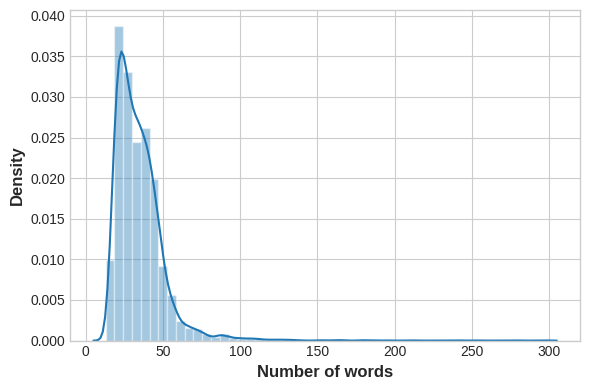

In [20]:
f,ax=plt.subplots(figsize=(6,4))
sns.distplot(tweet_len)
plt.xlabel('Number of words')

In [21]:
df_train=df_train[['pair2','label']]


In [22]:
df_train.head()

,pair2,label
0,"it[SEP]Tamara, tell him it has to be a real we...",3
1,researchers[SEP]But researchers and developmen...,6
2,your[SEP]Ascorbic acid also stimulates your bo...,3
3,parents[SEP]But I have never actively thought ...,4
4,OF[SEP]STUDY ON HEAT TRANSFER ENHANCEMENT OF F...,3


In [23]:
df_test=df_test[['pair2','label']]

In [24]:
df_test.head()

,pair2,label
0,mistake[SEP]I leave it as an exercise for you ...,1
1,mill[SEP]Baume hydrometers are ordinarily used...,9
2,"intrigue[SEP]The venture involved intrigue, li...",5
3,"twist[SEP]The twist with Icera’s chips, says S...",6
4,are protected[SEP]Article A sole proprietorshi...,7


# Cleaning the Tweets

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002702-\U000027B0"  # other miscellaneous symbols
                              u"\U000024C2-\U0001F251"  # enclosed characters
                              "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtags(text):
    pattern = r'(\B#\w+\b)|(\#\w+\b\s*$)'
    return re.sub(pattern, '', text)
def remove_specialchars(text):
    filtered_sent=[]
    for char in text.split(' '):
        if char=='&' or char=='$':
            filtered_sent.append('')
        else:
            filtered_sent.append(char)
    return ' '.join(filtered_sent)
def remove_extraspace(text):
    return re.sub('\s\s+','',text)
def clean_text(text):
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove links
    text = re.sub(r'http\S+|www\S+|\S+\.\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove \r\n new line characters
    text = text.replace('\r\n', ' ')
    return text
def strip(text):
    text = text.strip()
    return text

In [ ]:
df_train['pair']=df_train['pair'].apply(remove_emojis)
df_train['pair']=df_train['pair'].apply(remove_hashtags)
df_train['pair']=df_train['pair'].apply(remove_specialchars)
df_train['pair']=df_train['pair'].apply(remove_extraspace)
df_train['pair']=df_train['pair'].apply(clean_text)
df_train['pair']=df_train['pair'].apply(strip)

<ipython-input-30-dd52bbfa4316>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pair']=df_train['pair'].apply(remove_emojis)
<ipython-input-30-dd52bbfa4316>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pair']=df_train['pair'].apply(remove_hashtags)
<ipython-input-30-dd52bbfa4316>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [ ]:
df_train.head()

,pair,label
0,started[SEP]My wound has been aching ever sinc...,4
1,discovered[SEP]The alarm was raised as soon as...,4
2,liberated[SEP]The old prefessor came back to C...,4
3,studied[SEP]Objective Diagnosis and differenti...,4
4,"equipped[SEP]It is equipped with shotguns, tea...",4


In [ ]:
df_test['OriginalTweet']=df_test['OriginalTweet'].apply(remove_emojis)
df_test['OriginalTweet']=df_test['OriginalTweet'].apply(remove_hashtags)
df_test['OriginalTweet']=df_test['OriginalTweet'].apply(remove_specialchars)
df_test['OriginalTweet']=df_test['OriginalTweet'].apply(remove_extraspace)
df_test['OriginalTweet']=df_test['OriginalTweet'].apply(clean_text)

In [ ]:
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING New Yorkers encounter empty supermark...,0
1,When I couldnt find hand sanitizer at Fred Mey...,2
2,Find out how you can protect yourself and love...,2
3,buying hitsCity as anxious shoppers stock up ...,0
4,One week everyone buying baby milk powder the ...,1


In [ ]:
tweet_len = []
for text in df_train['pair']:
    tokens = tokenizer.encode(text, max_length=512)
    tweet_len.append(len(tokens))
print(np.max(tweet_len),np.min(tweet_len))

349 4


<ipython-input-22-aa8050e070b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet_len)


Text(0.5, 0, 'Number of words')

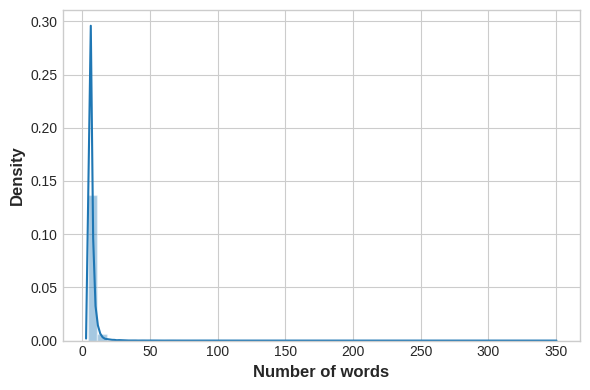

In [ ]:
f,ax=plt.subplots(figsize=(6,4))
sns.distplot(tweet_len)
plt.xlabel('Number of words')

In [ ]:
df_train['tweet_len'] = tweet_len
df_train = df_train.sort_values(by='tweet_len', ascending=False)
df_train.head(20)

<ipython-input-68-64b76b66bf33>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet_len'] = tweet_len


,pair,label,tweet_len
1506,"No pain, no palm; no thorns, no throne; no gal...",1,53
270,"No pain, no palm; no thorns, no throne; no gal...",1,53
1505,"No pain, no palm; no thorns, no throne; no gal...",1,52
269,"No pain, no palm; no thorns, no throne; no gal...",1,52
1511,One man may steal a horse while another may no...,1,32
275,One man may steal a horse while another may no...,1,32
1546,What you lose on the swings you gain (or get b...,1,31
310,What you lose on the swings you gain (or get b...,1,31
299,Things of a kind come together; people of a ki...,1,29
313,With time and patience the leaf of the mulberr...,1,29


In [ ]:
tweet_len_test = []
for text in df_test['OriginalTweet']:
    tokens = tokenizer.encode(text, max_length=512)
    tweet_len_test.append(len(tokens))
print(np.max(tweet_len_test),np.min(tweet_len_test))

df_test['tweet_len_test'] = tweet_len_test
df_test = df_test.sort_values(by='tweet_len_test', ascending=False)
df_test.head()

116 4


,OriginalTweet,Sentiment,tweet_len_test
3316,If I dont die from19 its because I will die of...,0,116
1015,totemranch613 sohos1963 Thisas bad for the as ...,0,115
1421,THISIS SHOWING THE TRUE COLORS OF GREEDY amp S...,0,112
2383,Ahora seguid llorando por el papel higiénico q...,0,107
286,Rhett800cc So hard to decide As much as I want...,0,107


In [25]:
#shuffle train data and reset index
df_train=df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,pair2,label
0,Costumed[SEP]Costumed characters were doing mo...,6
1,miles[SEP]I will get $2. 70 in cash rebates an...,4
2,"be examined[SEP]Then, when some interface chan...",4
3,drink[SEP]They work by absorbing extra thermal...,9
4,she[SEP]She felt she could console the child b...,3


In [26]:
df_test=df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,pair2,label
0,a black eye[SEP]Uncle George got a black eye f...,5
1,are analyzed[SEP]Through comparison of convent...,7
2,responses[SEP]Companies caught up in funny bus...,6
3,methane[SEP]The discovery follows a string of ...,1
4,weak[SEP]Those costs that might be small for e...,0


In [27]:
df_train.label.value_counts()

0    11231
1     9000
2     8946
3     8500
4     8309
5     7914
6     7574
7     7177
8     5401
9     3535
Name: label, dtype: int64

# Oversampling of train data

In [ ]:
oversampler=RandomOverSampler()
OriginalTweet_os,Sentiment_os=oversampler.fit_resample(np.array(df_train['pair']).reshape(-1, 1), np.array(df_train['label']).reshape(-1, 1))
df_train_os= pd.DataFrame(list(zip([x[0] for x in OriginalTweet_os],Sentiment_os)), columns = ['pair','label'])

In [28]:
df_train_os = df_train
df_train_os.label.value_counts()

0    11231
1     9000
2     8946
3     8500
4     8309
5     7914
6     7574
7     7177
8     5401
9     3535
Name: label, dtype: int64

# Splitting the data into train/valid/test

In [29]:
# X1=df_train_os['pair1'].values
X=df_train_os['pair2'].values
y=df_train_os['label'].values

In [30]:
# X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1,X2,y,test_size=0.1,stratify=y,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,stratify=y,random_state=42)

In [31]:
print(X_train)
print()

['kilograms[SEP]For the 1-5 kilograms (including 1 kilogram) of drugs per package, one piece shall be fetched as a sample every 50 kilograms, those not more than 50 kilograms shall be considered as 50 kilograms;'
 'they[SEP]This approach not only lets anyone download the raw data, but also enables them to query it for whatever they have in mind.'
 'be phased[SEP]Even so, to allay public concern, the use of antibiotic resistance genes will probably be phased out in the next five years.'
 ...
 'with[SEP]And God dealt well with the midwives, and the people multiplied and grew very strong.'
 'often[SEP]Women diagnosed with breast cancer who have an abnormal BRCA1 or BRCA2 gene often have a family history of breast cancer, ovarian cancer, or both.'
 'have[SEP]Reports have now emerged that President Obama has signed an executive order some time this year, authorizing covert support to help the rebels oust Mr Assad.']



In [32]:
# X1_test=df_test['pair1'].values
X_test=df_test['pair2'].values
y_test=df_test['label'].values

In [33]:
y_train_label=y_train.copy()
y_val_label=y_val.copy()
y_test_label=y_test.copy()

In [34]:
hotencoder=preprocessing.OneHotEncoder()
y_train=hotencoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val=hotencoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test=hotencoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# Model2: BERT Model

In [35]:
MAX_LEN=512

In [36]:
def tokenize(tweets,max_len=MAX_LEN):
    input_ids=[]
    attention_masks=[]
    for i in range(len(tweets)):
        encoding=tokenizer.encode_plus(tweets[i],add_special_tokens=True,max_length=MAX_LEN,
                                       padding='max_length',return_attention_mask=True)
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [39]:
print(X_train)

['kilograms[SEP]For the 1-5 kilograms (including 1 kilogram) of drugs per package, one piece shall be fetched as a sample every 50 kilograms, those not more than 50 kilograms shall be considered as 50 kilograms;'
 'they[SEP]This approach not only lets anyone download the raw data, but also enables them to query it for whatever they have in mind.'
 'be phased[SEP]Even so, to allay public concern, the use of antibiotic resistance genes will probably be phased out in the next five years.'
 ...
 'with[SEP]And God dealt well with the midwives, and the people multiplied and grew very strong.'
 'often[SEP]Women diagnosed with breast cancer who have an abnormal BRCA1 or BRCA2 gene often have a family history of breast cancer, ovarian cancer, or both.'
 'have[SEP]Reports have now emerged that President Obama has signed an executive order some time this year, authorizing covert support to help the rebels oust Mr Assad.']


In [37]:
train_input_ids,train_attention_masks=tokenize(X_train,MAX_LEN)
test_input_ids,test_attention_masks=tokenize(X_test,MAX_LEN)
val_input_ids,val_attention_masks=tokenize(X_val,MAX_LEN)



In [38]:
print(train_input_ids)

[[  101 86754 31253 ...     0     0     0]
 [  101 10689   102 ...     0     0     0]
 [  101 10347 20394 ...     0     0     0]
 ...
 [  101 10169   102 ...     0     0     0]
 [  101 12899   102 ...     0     0     0]
 [  101 10529   102 ...     0     0     0]]


In [38]:
bert_model=TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
def create_model(bert_model,max_len=MAX_LEN):

    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    accuracy=tf.keras.metrics.CategoricalAccuracy()

    input_ids=tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks=tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings=bert_model([input_ids,attention_masks])[1]
    output=tf.keras.layers.Dense(10,activation='softmax')(embeddings)
    model=tf.keras.models.Model(inputs=[input_ids,attention_masks],outputs=output)
    model.compile(optimizer,loss=loss_fn,metrics=accuracy)

    return model


In [40]:
model=create_model(bert_model,MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([val_input_ids, val_attention_masks], y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop]  # Pass the early_stop callback
)



Epoch 1/50
  20/4365 [..............................] - ETA: 24:47 - loss: 2.3062 - categorical_accuracy: 0.1406

KeyboardInterrupt: ignored

In [ ]:
res=model.predict([test_input_ids,test_attention_masks])
y_pred_bert=np.zeros_like(res)
y_pred_bert[np.arange(len(y_pred_bert)),res.argmax(1)]=1

270/270 [==============================] - 42s 145ms/step


In [ ]:
confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1))

array([[889,  53,   0,  88,  20,  12,  52,  88,  30,  16],
       [144, 591,   0,   0,  96,  17,  72,  29,  25,  26],
       [  0,   0, 994,   0,   0,   0,   0,   0,   0,   0],
       [ 14,   0,   0, 922,   0,   0,   0,   0,   5,   4],
       [  3,  23,   0,   0, 800,   4,  39,  42,   4,   8],
       [ 12,  10,   0,   0,   6, 805,  14,  20,   3,   9],
       [ 38,  27,   0,  10,  69,  11, 649,   2,  19,  17],
       [ 36,  11,   0,   3,  68,  51,   5, 620,   3,   0],
       [ 22,  14,   0,  27,  20,   5,  55,   3, 446,   8],
       [ 48,  31,   0,   2,  38,   4,  54,   4,  16, 196]])

In [ ]:
class_labels=['literal','transposition','unaligned_explicitation','unaligned_reduction','lexical_shift','equivalence','generalization','modulation','particularization','modulation_transposition']


In [ ]:
# bert only  en+en_sent
print(classification_report(y_test.argmax(1),y_pred_bert.argmax(1),target_names=class_labels))

                          precision    recall  f1-score   support

                 literal       0.74      0.71      0.72      1248
           transposition       0.78      0.59      0.67      1000
 unaligned_explicitation       1.00      1.00      1.00       994
     unaligned_reduction       0.88      0.98      0.92       945
           lexical_shift       0.72      0.87      0.78       923
             equivalence       0.89      0.92      0.90       879
          generalization       0.69      0.77      0.73       842
              modulation       0.77      0.78      0.77       797
       particularization       0.81      0.74      0.77       600
modulation_transposition       0.69      0.50      0.58       393

                accuracy                           0.80      8621
               macro avg       0.80      0.79      0.79      8621
            weighted avg       0.80      0.80      0.80      8621



<Axes: >

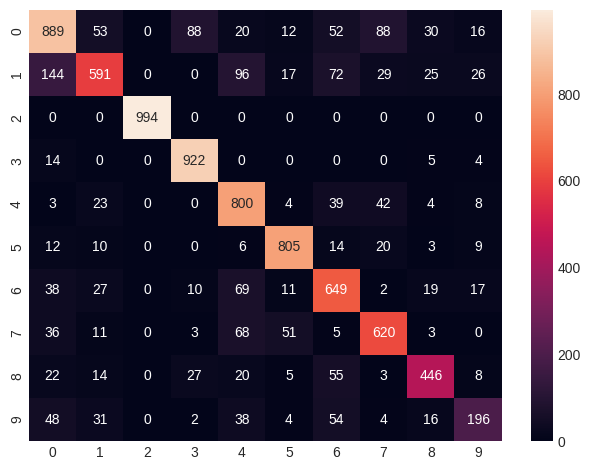

In [ ]:
sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)),annot=True,fmt="d")